# 06. PyTorch Transfer Learning
What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.
* Pretrained model = foundation models

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from xlwings.utils import col_name

from going_modular.train import train_dir, train_dataloader, test_dataloader, optimizer

print(torch.__version__)
print(torchvision.__version__)

from going_modular import data_setup, engine

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0980 | train_acc: 0.3984 | test_loss: 1.1003 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1020 | train_acc: 0.3047 | test_loss: 1.1053 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0974 | train_acc: 0.3047 | test_loss: 1.0953 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1031 | train_acc: 0.3047 | test_loss: 1.0883 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0914 | train_acc: 0.3320 | test_loss: 1.0904 | test_acc: 0.4432
[INFO] Saving model to: models/05_going_modular_script_mode_tinyvgg_model.pth
2.5.1
0.20.1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu"))
device

device(type='mps')


## 1. Get data
We need our pizza, steak, sushi data to build a transfer learning model on

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download and prepare it...
if image_path.is_dir():
    print(f"{image_path} exists")
else:
    print(f"{image_path} does not exist, downloading it")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Extracting pizza_steak_sushi.zip")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi exists


In [4]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets and DataLoaders

Now we've got the data, we want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:
1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

## 2.1 Creating a transform for torchvision. models (manual creation)
`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.\

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.

In [5]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transforms = transforms.Compose([transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
                                         transforms.ToTensor (), # get images into range [0, 1]
                                         normalize]) # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)|

In [6]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = 32,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1571d6ff0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

In [7]:
import torchvision
torchvision.__version__

'0.20.1'

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = auto_transforms,
    batch_size = 32,
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15717d4f0>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model
There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experimentation*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.
Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (Like a self-driving car)

Or does it live on a server?

Looking at https://docs.pytorch.org/vision/stable/models.html

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetBO is one of our best options in terms performance vs size.

However, in light of the bitter lesson if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could use.

### 3.2 Setting up a pretrained model
Want to create an instance of a pretrained EffNetBO - https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [31]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary`

In [33]:
# Print with torchinfo
from torchinfo import summary

summary_args = {
    "model":model,
    "input_size":(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
    "col_names":["input_size", "output_size", "num_params", "trainable"],
    "col_width":20,
    "row_settings":["var_names"]
}
summary(**summary_args)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the putput layer to suit our needs

With a feature extractor model, typically you will "freeze" the base layers of the pretrained/foundation model and update the output layers to suit your own problem.

In [34]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [38]:
# Update the classifier head of our model ro suit our problem
from torch import nn

torch.manual_seed(42)
torch.mps.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True),
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [39]:
summary(**summary_args)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# 4. Train model

In [41]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)
model.to(device)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Setup training and saving the results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0823 | train_acc: 0.4062 | test_loss: 0.8991 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.8564 | train_acc: 0.7695 | test_loss: 0.7927 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7914 | train_acc: 0.7891 | test_loss: 0.7373 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7206 | train_acc: 0.7500 | test_loss: 0.6338 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6368 | train_acc: 0.7812 | test_loss: 0.6190 | test_acc: 0.8665
[INFO] Total training time: 386.877 seconds


# 5. Evaluate model by plotting loss curves

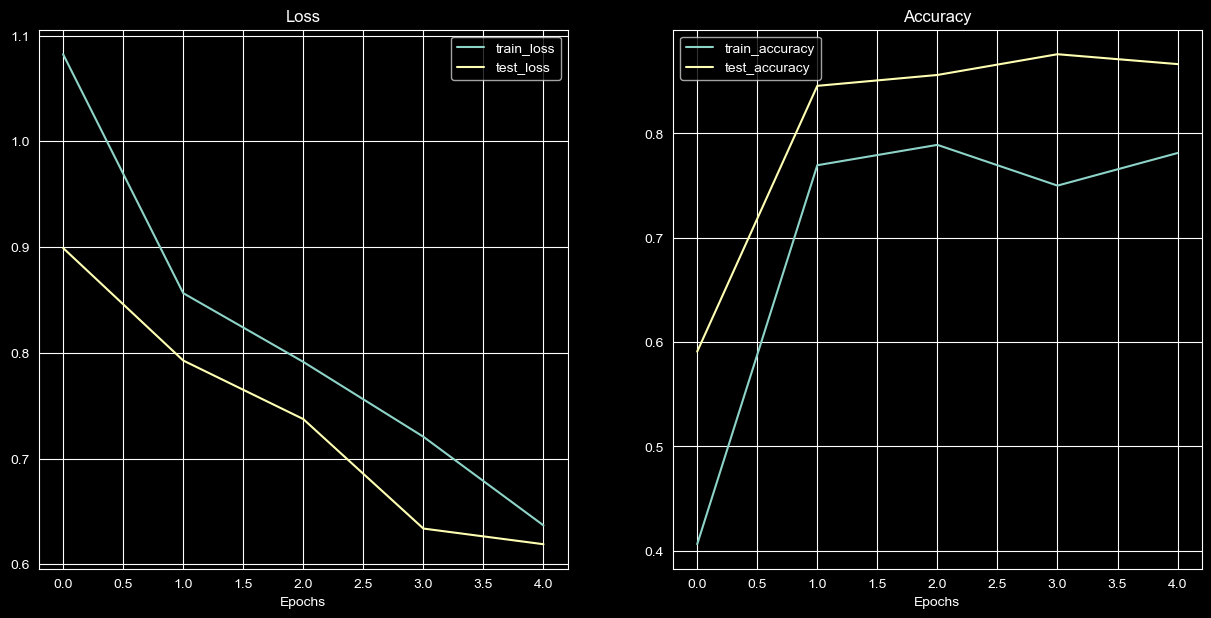

In [46]:
from helper_functions import plot_loss_curves
# Plot the loss curves of our model
plot_loss_curves(results)

# 6. Make prediction on images from the test data

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*!

And make some qualitative predictions on our test set.

Some things to keep in mind when making predictions/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automagically, let's create a function called 'pred_and_plot_image()`:

The function will be similar to the one here: `04 pytorch custom datasets/11.3-putting-custom-image-prediction-together-building-a-function`

1. Take in a trained model, a list of class names, a filepath to a target image, an img size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like 'nn.Dropout()`)
6. Transform the target image and make sure it's suited for the model (relates to the batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8

In [54]:
type(.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))
transforms.

torchvision.transforms.transforms.Compose

In [90]:
from typing import List, Tuple, Optional, Callable
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str | Path,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: Optional[Callable[[Image.Image], torch.Tensor]]  = None,
                        device: torch.device = device):
    # 2. Open the image with PIL
    img = Image.open(image_path)

    # Create a transform if one doesn't exist
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((image_size[0], image_size[1])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    ### Predict on Image ###
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference model and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. transform the image and add an extra batch dimension
        transformed_image = transform(img).unsqueeze(dim=0) # [batch_size, c_ch, H, W]

        # 7. Make a prediction on the transformed image by passing it to the model + ensuring it's on the target device
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the mode's pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot the image with image label and prob
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis('off')
    plt.show()

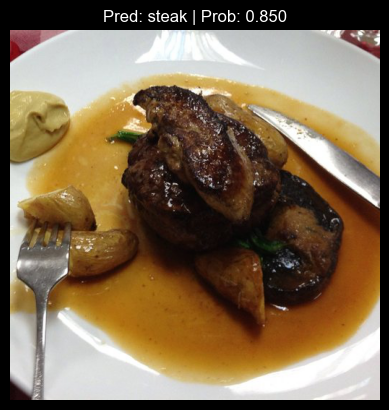

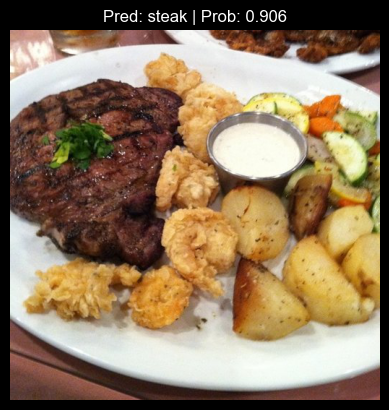

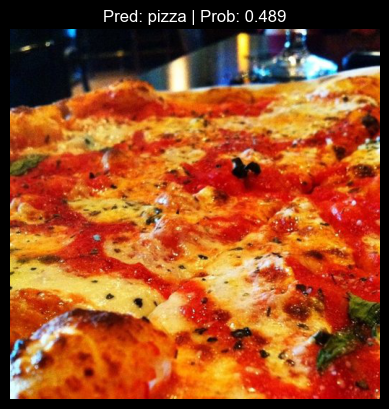

In [91]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).rglob("*/*.jpg"))

rand_imgs_samples = random.sample(test_image_path_list, k=num_images_to_plot)

# Make predictions on and plot the images
for img_path in rand_imgs_samples:
    pred_and_plot_image(
        model=model,
        image_path=img_path,
        class_names=class_names,
    )

In [95]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

## 6.1 Making prediction son a custom image
Let's make a prediction on the pizza dad image - `data/04-pizza-dad.jpeg`

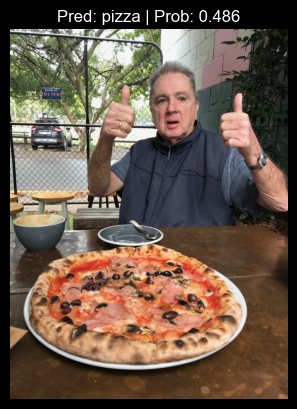

In [96]:
pred_and_plot_image(
    model=model,
    image_path=Path("data/04-pizza-dad.jpeg"),
    class_names=class_names,
)

In [101]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print
update_progress(video_index=199, done=True)

Updated progress report. 
Video: 199. Main Takeaways, Exercises and Extra- Curriculum 
Duration: 3m 
Status: Done 
Date: 13 Dec 2025 12:43 PM 
Section progress: 
Section : 8.PyTorch Transfer Learning
Status  : Done
Progress: 100%|█████████████████████████████ 19/19


In [103]:
progress_report_print()

      ___         ___           ___           ___           ___           ___           ___           ___     
     /  /\       /  /\         /  /\         /  /\         /  /\         /  /\         /  /\         /  /\    
    /  /::\     /  /::\       /  /::\       /  /:/_       /  /::\       /  /:/_       /  /:/_       /  /:/_   
   /  /:/\:\   /  /:/\:\     /  /:/\:\     /  /:/ /\     /  /:/\:\     /  /:/ /\     /  /:/ /\     /  /:/ /\  
  /  /:/~/:/  /  /:/~/:/    /  /:/  \:\   /  /:/_/::\   /  /:/~/:/    /  /:/ /:/_   /  /:/ /::\   /  /:/ /::\ 
 /__/:/ /:/  /__/:/ /:/___ /__/:/ \__\:\ /__/:/__\/\:\ /__/:/ /:/___ /__/:/ /:/ /\ /__/:/ /:/\:\ /__/:/ /:/\:\
 \  \:\/:/   \  \:\/:::::/ \  \:\ /  /:/ \  \:\ /~~/:/ \  \:\/:::::/ \  \:\/:/ /:/ \  \:\/:/~/:/ \  \:\/:/~/:/
  \  \::/     \  \::/~~~~   \  \:\  /:/   \  \:\  /:/   \  \::/~~~~   \  \::/ /:/   \  \::/ /:/   \  \::/ /:/ 
   \  \:\      \  \:\        \  \:\/:/     \  \:\/:/     \  \:\        \  \:\/:/     \__\/ /:/     \__\/ /:/  
 